In [241]:
import torch
from botorch.models import SingleTaskGP
from botorch.models.transforms import Normalize, Standardize
from botorch.fit import fit_gpytorch_mll
from botorch.acquisition import LogExpectedImprovement, UpperConfidenceBound
from botorch.acquisition.analytic import LogProbabilityOfImprovement, ProbabilityOfImprovement
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch.optim import optimize_acqf
from botorch.models.cost import AffineFidelityCostModel
import numpy as np
import matplotlib.pyplot as plt
from botorch.acquisition.analytic import AnalyticAcquisitionFunction
from botorch.acquisition.utils import repeat_to_match_aug_dim
from abc import ABC, abstractmethod

def poly(x):
    return (-0.001 * x**6 + 0.003 * x**5 + 0.062 * x**4 - 
            0.174 * x**3 - 0.673 * x**2 + 1.323 * x + 1.764)

In [242]:
train_X = np.random.uniform(low = -5, high = 5, size = 10)
Y = poly(train_X)
Y = torch.tensor(Y.reshape(-1,1))
Y = Y  #+ 0.1 * torch.randn_like(Y)  # add some noise
train_X = torch.tensor(train_X.reshape(-1,1))

In [243]:
gp = SingleTaskGP(
  train_X=train_X,
  train_Y=Y,
  input_transform=Normalize(d=1),
  outcome_transform=Standardize(m=1),
)


In [ ]:
from botorch.acquisition import ProbabilityOfImprovement

import torch
from torch import Tensor
from botorch.acquisition import qUpperConfidenceBound, qProbabilityOfImprovement, qLogExpectedImprovement
from botorch.acquisition.monte_carlo import SampleReducingMCAcquisitionFunction

In [ ]:
class AnalyticAcquisitionFunctionWithCost(AnalyticAcquisitionFunction):
    """
    This is the acquisition function EI(x) - c(x), where alpha is a decay
    factor that reduces or increases the emphasis of the cost model c(x).
    """

    def __init__(self, model, acqf, cost_model):
        super().__init__(model=model)
        self.model = model
        self.cost_model = cost_model
        self.acqf = acqf

    def forward(self, X):
        return self.acqf(X) - self.cost_model(X)[:, 0]
    
class MCAcquisitionFunctionWithCost(SampleReducingMCAcquisitionFunction):

    def __init__(self, model, acqf, cost_model):
    
        super().__init__(model=model)
        self.acqf = acqf
        self.cost_model = cost_model

    def _non_reduced_forward(self, X: Tensor) -> Tensor:
        """Compute the constrained acquisition values at the MC-sample, q level.

        Args:
            X: A `batch_shape x q x d` Tensor of t-batches with `q` `d`-dim
                design points each.

        Returns:
            A Tensor with shape `sample_sample x batch_shape x q`.
        """

        X_flat = X.view(-1, X.size(-1))
        costs_flat = self.cost_model(X_flat) 
        costs = costs_flat.view(X.shape[0], X.shape[1])
        costs = costs.unsqueeze(0).expand(self.sample_shape[0], -1, -1)

        samples, obj = self._get_samples_and_objectives(X)
        obj = obj - costs
        samples = repeat_to_match_aug_dim(target_tensor=samples, reference_tensor=obj)
        acqval = self._sample_forward(obj)  # `sample_sample x batch_shape x q`
        return self._apply_constraints(acqval=acqval, samples=samples)

    def _sample_forward(self, obj: Tensor) -> Tensor:
        return self.acqf._sample_forward(obj)
    


In [296]:
class CostModel(torch.nn.Module, ABC):
    """
    Simple abstract class for a cost model.
    """

    @abstractmethod
    def forward(self, X):
        pass

class ingredient_cost(CostModel):
    def __init__(self, weights, fixed_cost):
        super().__init__()
        self.weights = weights
        self.fixed_cost = fixed_cost
        self.model =  AffineFidelityCostModel(fidelity_weights=weights, fixed_cost=fixed_cost)

    def forward(self, X):
        return self.model(X)[:, 0]

In [ ]:
cost = ingredient_cost(weights={0:0.0}, fixed_cost=1e-5)

tensor([[ 2.3527],
        [ 1.5632],
        [ 3.3645],
        [ 4.3019],
        [ 3.8957],
        [-0.7918],
        [ 1.6948],
        [ 0.9129],
        [ 3.3764],
        [-2.9138]], dtype=torch.float64)

In [399]:
EI = LogExpectedImprovement(gp, Y.max())
Eic= AnalyticAcquisitionFunctionWithCost(gp,
                                    EI,
                                    cost)

In [402]:
bounds = torch.stack([torch.zeros(1), torch.ones(1)]).to(torch.double)
candidate, acq_value = optimize_acqf(
  Eic, bounds=bounds, q=1, num_restarts=100, raw_samples=200,
)
candidate  # tensor([[0.2981, 0.2401]], dtype=torch.float64)

tensor([[0.8870]], dtype=torch.float64)

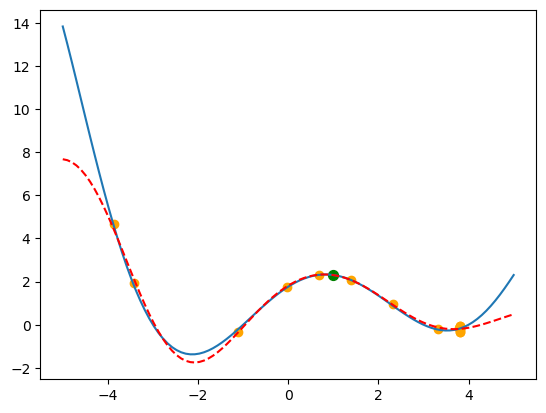

In [54]:
plot_x = np.linspace(-5,5,100)
plot_y = poly(plot_x)
plot_x_tensor = torch.tensor(plot_x.reshape(-1,1))
with torch.no_grad():
    gp_mean, gp_var = gp.posterior(plot_x_tensor).mean, gp.posterior(plot_x_tensor).variance


plt.plot(plot_x,plot_y)
plt.scatter(train_X,Y, color = 'orange')
plt.plot(plot_x_tensor.numpy(), gp_mean.numpy(), label="GP Mean", color="red", linestyle='dashed')
plt.scatter(candidate, poly(candidate), color = 'green', marker='o', s= 50)

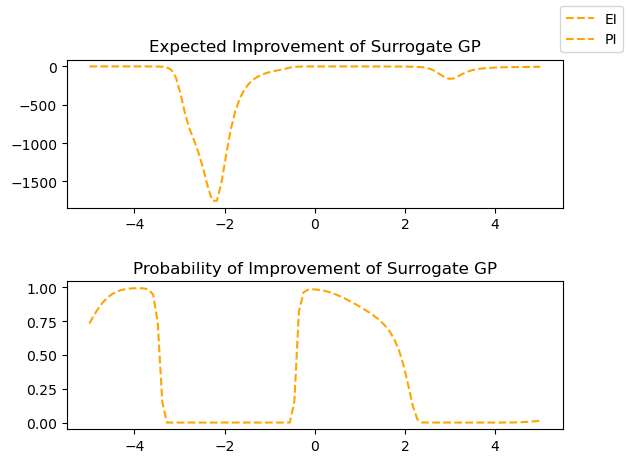

In [30]:
ei = logEI(plot_x_tensor.unsqueeze(-2)).detach()
pi = PI(plot_x_tensor.unsqueeze(-2)).detach()
fig, axs = plt.subplots(2)
axs[0].plot(plot_x_tensor.numpy(), ei.numpy(), color="orange", linestyle='dashed', label='EI')
axs[0].set_title("Expected Improvement of Surrogate GP")
fig.subplots_adjust(hspace=0.5)
axs[1].plot(plot_x_tensor.numpy(), pi.numpy(), color="orange", linestyle='dashed', label='PI')
axs[1].set_title("Probability of Improvement of Surrogate GP")
fig.legend()